In [16]:
from urllib.request import urlopen
from urllib.error import HTTPError
from bs4 import BeautifulSoup
import re
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns 
from tqdm import tqdm

%matplotlib inline

In [17]:
#Using the List of Controversial Issues page, grab names of all of the controversial topics on Wikipedia 
html = urlopen('https://en.wikipedia.org/wiki/Wikipedia:List_of_controversial_issues')
bs = BeautifulSoup(html, 'html.parser')
allLinks = []
various_not_allowed = ['Wikipedia', '%', 'http', 'www']
for link in bs.find_all('a'):
    if 'href' in link.attrs:
        if 'wiki' in link.attrs['href']:
            if various_not_allowed[0] not in link.attrs['href']:
                if various_not_allowed[1] not in link.attrs['href']:
                    if various_not_allowed[2] not in link.attrs['href']:
                        if various_not_allowed[3] not in link.attrs['href']:
                            allLinks.append(link.attrs['href'])
del allLinks[0]
allLinks = allLinks[:-26]
print(allLinks)
return(allLinks)

['/wiki/2003_invasion_of_Iraq', '/wiki/Abortion', '/wiki/Affirmative_action', '/wiki/African_National_Congress', '/wiki/Alberta_separatism', '/wiki/American_Civil_Liberties_Union', '/wiki/American_Hunters_and_Shooters_Association', '/wiki/History_of_the_Jews_in_the_United_States', '/wiki/American_Jews', '/wiki/Anarchism', '/wiki/Anarcho-capitalism', '/wiki/Anti-Americanism', '/wiki/Anti-clericalism', '/wiki/Anti-Irish_racism', '/wiki/Anti-semitism', '/wiki/Asian_American', '/wiki/Atheism', '/wiki/Austrian_School', '/wiki/Bashar_Assad', '/wiki/Syrian_Civil_War', '/wiki/Bidoon_(social_class)', '/wiki/Black_Lives_Matter', '/wiki/Black_supremacy', '/wiki/Boricua_Popular_Army', '/wiki/Brexit', '/wiki/British_National_Party', '/wiki/Capitalism', '/wiki/Capital_punishment', '/wiki/Catalonia', '/wiki/Cherokee', '/wiki/China', '/wiki/East_Turkestan_Independence_Movement', '/wiki/Tibetan_independence_movement', '/wiki/Human_rights_in_China', '/wiki/Chinese_intelligence_activity_abroad', '/wiki/C

SyntaxError: 'return' outside function (<ipython-input-17-98fa93e39c88>, line 17)

In [18]:
#This function grabs the change request history for any give page. 
def grab_all_history(url, topic, df_all_history):
    print(url)
    dif_url = None
    link_still_there = True
    page_no = 1
    # While statement loops through all pages of the change history
    while link_still_there:
        now = datetime.now()
        print("Starting page " + str(page_no) + " at " + now.strftime("%m/%d/%Y, %H:%M:%S"))
        html = urlopen(url)
        bs = BeautifulSoup(html, 'html.parser')
        if page_no == 100:
            print("Data dumped to file before continuing")
            df_all_history.to_csv('wikipedia_controversial.csv', header=None, mode='a')
            print(df_all_history.shape)
            page_no = 0
            df_all_history.drop(df_all_history.index, inplace=True)
            print(df_all_history.shape)
        # Changes are in <li>, but not all li
        for li_tag in bs.find_all('li'):
            tags = []
            has_no_comment = True
            first_tag_comment = True
            line_for_append = [url, topic]
            # data-mw-revid begins the insert for each change
            if 'data-mw-revid' in li_tag.attrs:
                # dates and user names exist inside of <a> tags
                for a_tag in li_tag.find_all('a'):
                    if str(a_tag).__contains__('prev') and str(a_tag).__contains__('diff'):
                        dif_url = 'https://en.wikipedia.org' + str(a_tag.attrs['href'])
                        full_diff = []
                        final_marker = ['','']
                        dif_html = urlopen(dif_url)
                        dif_bs = BeautifulSoup(dif_html, 'html.parser')
                        dif_table = dif_bs.findAll("table")
                        for div in dif_table:
                            rows = div.findAll('tr')
                            for row in rows :
                                diffs_list = []
                                lineno = row.findAll('td', {"class": "diff-lineno"})
                                if lineno:
                                    for tds in row.findAll('td'):
                                        if tds.text == '\xa0':
                                            diffs_list.append(" ")
                                        else:
                                            diffs_list.append(" ")
                                            diffs_list.append(tds.text)
                                classes = row.findAll('td', {"class": ["diff-context", "diff-addedline", "diff-deletedline", "diff-empty"]})
                                if classes:
                                    for tds in row.findAll('td'):
                                        if tds.text == '\xa0':
                                            diffs_list.append(" ")
                                        else:
                                            diffs_list.append(tds.text)
                                if diffs_list:
                                    if len(diffs_list) == 3:
                                        if diffs_list[0] == ' ':
                                            diffs_list.insert(0, ' ')
                                        else:
                                            diffs_list.append(' ')
                                    full_diff.append(diffs_list)
                    # Date
                    if str(a_tag).__contains__('mw-changeslist-date'):
                        line_for_append.append(a_tag.text)
                    # User
                    if str(a_tag).__contains__('mw-userlink'):
                        line_for_append.append(a_tag.text)
                # All other data exists inside of <span> tags
                for span_tag in li_tag.find_all('span'):
                    # Bytes
                    if str(span_tag).__contains__('data-mw-bytes'):
                        line_for_append.append(span_tag.text)
                    # Number of changes
                    if str(span_tag).__contains__('mw-plusminus'):
                        line_for_append.append(span_tag.text)
                    # Comments
                    if str(span_tag).__contains__('comment') and has_no_comment:
                        line_for_append.append(span_tag.text)
                        has_no_comment = False
                    # Tags
                    if str(span_tag).__contains__('mw-tag-marker'):
                        if first_tag_comment:
                            first_tag_comment = False
                        else:
                            splits = re.split('>', str(span_tag))
                            if str(span_tag).__contains__('href'):
                                tags.append(splits[-3][:-3])
                            else:
                                tags.append(splits[-2][:-6])
                # In the case that there are no comments
                if has_no_comment:
                    line_for_append.append("No comment")
            line_for_append.append(tags)
            if dif_url:
                line_for_append.append(dif_url)
                line_for_append.append(full_diff)
                #print(dif_url)
                #print(full_diff)
            # add line to dataframe
            try:
                df_all_history.loc[len(df_all_history)] = line_for_append
                #print(df_all_history.head())
            except:
                continue
        url = ''
        # Get next page of history
        for a_tag in bs.find_all('a'):
            if str(a_tag).__contains__('mw-nextlink'):
                url = 'https://en.wikipedia.org' + str(a_tag.attrs['href'])
                #print(url)
        # If no next page, break while loop
        if url == '':
            link_still_there = False
        page_no = page_no + 1
    return(df_all_history)

In [45]:
def grab_all_history(url, topic):
    df_this_history = pd.DataFrame(columns=['Page', 'Topic', 'Date of Change', 'User', 'Bytes', 'Number of Changes', 'Comments', 'Tags', 'Link To Diff'])
    dif_url = None
    page_no = 1
    yesterday = datetime.now() - timedelta(days = 30)
    latest_date = datetime.now()
    predict_change_num = 0
    predict_comment = 0
    while latest_date > yesterday:
        try:
            full_diff = []
            html = urlopen(url)
            bs = BeautifulSoup(html, 'html.parser')
            for li_tag in bs.find_all('li'):
                tags = []
                has_no_comment = True
                first_tag_comment = True
                line_for_append = [url, topic]
                if 'data-mw-revid' in li_tag.attrs:
                    for a_tag in li_tag.find_all('a'):
                        if str(a_tag).__contains__('prev') and str(a_tag).__contains__('diff'):
                            dif_url = 'https://en.wikipedia.org' + str(a_tag.attrs['href'])
                            final_marker = ['','']
                            dif_html = urlopen(dif_url)
                            dif_bs = BeautifulSoup(dif_html, 'html.parser')
                            dif_table = dif_bs.findAll("table")
                            for div in dif_table:
                                rows = div.findAll('tr')
                                for row in rows :
                                    diffs_list = []
                                    lineno = row.findAll('td', {"class": "diff-lineno"})
                                    if lineno:
                                        for tds in row.findAll('td'):
                                            if tds.text == '\xa0':
                                                diffs_list.append(" ")
                                            else:
                                                diffs_list.append(" ")
                                                diffs_list.append(tds.text)
                                    classes = row.findAll('td', {"class": ["diff-context", "diff-addedline", "diff-deletedline", "diff-empty"]})
                                    if classes:
                                        for tds in row.findAll('td'):
                                            if tds.text == '\xa0':
                                                diffs_list.append(" ")
                                            else:
                                                diffs_list.append(tds.text)
                                    if diffs_list:
                                        if len(diffs_list) == 3:
                                            if diffs_list[0] == ' ':
                                                diffs_list.insert(0, ' ')
                                            else:
                                                diffs_list.append(' ')
                                        full_diff.append(diffs_list)
                        if str(a_tag).__contains__('mw-changeslist-date'):
                            line_for_append.append(a_tag.text)
                            latest_date = datetime.strptime(a_tag.text, '%H:%M, %d %B %Y')
                            if latest_date < yesterday:
                                return(df_this_history)
                        if str(a_tag).__contains__('mw-userlink'):
                            line_for_append.append(a_tag.text)
                    for span_tag in li_tag.find_all('span'):
                        if str(span_tag).__contains__('data-mw-bytes'):
                            line_for_append.append(span_tag.text)
                        if str(span_tag).__contains__('mw-plusminus'):
                            predict_change_num = check_change(span_tag.text)
                            line_for_append.append(span_tag.text)
                        if str(span_tag).__contains__('comment') and has_no_comment:
                            predict_comment = check_comments(span_tag.text)
                            line_for_append.append(span_tag.text)
                            has_no_comment = False
                        if str(span_tag).__contains__('mw-tag-marker'):
                            if first_tag_comment:
                                first_tag_comment = False
                            else:
                                splits = re.split('>', str(span_tag))
                                if str(span_tag).__contains__('href'):
                                    tags.append(splits[-3][:-3])
                                else:
                                    tags.append(splits[-2][:-6])
                    if has_no_comment:
                        line_for_append.append("No comment")
                line_for_append.append(tags)
                if dif_url:
                    line_for_append.append(dif_url)
                diff_as_string = ''.join([str(elem) for elem in full_diff])
                predict_diff = check_dif(diff_as_string)
                if predict_change_num:
                    try:
                        #print(predict_comment)
                        if predict_comment[0][1] > 0.40:
                            df_this_history.loc[len(df_this_history)] = line_for_append
                    except:
                        continue
            url = ''
            for a_tag in bs.find_all('a'):
                if str(a_tag).__contains__('mw-nextlink'):
                    url = 'https://en.wikipedia.org' + str(a_tag.attrs['href'])
        except:
            print('Broken Link ' + url)
    return(df_this_history)
""""""
url = 'https://en.wikipedia.org/w/index.php?title=Wikipedia:List_of_controversial_issues&action=history'
topic = 'List of Controversial Issues'
df_all_history = pd.DataFrame(columns=['Page', 'Topic', 'Date of Change', 'User', 'Bytes', 'Number of Changes', 'Comments', 'Tags', 'Link To Diff'])
df_all_history = grab_all_history(url, topic)
df_all_history.head(50)

,Page,Topic,Date of Change,User,Bytes,Number of Changes,Comments,Tags,Link To Diff


In [20]:
def check_dif(string_to_check):
    for item in ['[', ']', '* ', "' '", 'Line ', ':']:
        try:
            string_to_check = string_to_check.replace(item, "")
        except:
            print(string_to_check)
    with open('tf_text_est.dill', 'rb') as f:
        predict_tf_text = dill.load(f)
        return(predict_tf_text.predict_proba([string_to_check]))


In [37]:
def check_change(change_num):
    try:
        if change_num[0] == '+':
            num = int(change_num)
            return(True)
        else:
            return(False)
    except:
        return(False)
    #with open('tf_num_changes_est.dill', 'rb') as f:
    #    predict_tf_change_num = dill.load(f)
    #    return(predict_tf_change_num.predict([[num]]))#, predict_tf_change_num.apply([[num]]))

In [22]:
def check_comments(comment):
    with open('tf_comments_est.dill', 'rb') as f:
        predict_comment = dill.load(f)
        return(predict_comment.predict_proba([comment]))

In [ ]:
url = 'https://en.wikipedia.org/w/index.php?title=Wikipedia:List_of_controversial_issues&action=history'
topic = 'List of Controversial Issues'
df_all_history = pd.DataFrame(columns=['Page', 'Topic', 'Date of Change', 'User', 'Bytes', 'Number of Changes', 'Comments', 'Tags', 'Link To Diff'])

result = 1
for topic in tqdm(allLinks):
	#Run through every controversial topic, and grab change history
    #if result <= 67: #Communist party the unites states
    #    print("not " + topic)
    #else:
    url = 'https://en.wikipedia.org/w/index.php?title=:' + topic[6:] + '&action=history'
    topic = topic[6:]
    df_all_history = pd.concat([df_all_history, grab_all_history(url, topic)])
    print(df_all_history.shape)
    #if df_all_history.shape[0] > 20:
df_all_history.to_csv("todays_entries.csv", index = False)
print(df_all_history.head())
#break

            #history_list = [df_all_history.columns.values.tolist()] + df_all_history.values.tolist()
            #print(history_list)
    #df_all_history.to_csv('wikipedia_controversial.csv', header=None, mode='a')
    #df_all_history = pd.DataFrame(columns=['Page', 'Topic', 'Date of Change', 'User', 'Bytes', 'Number of Changes', 'Comments', 'Tags', 'Link To Diff', 'Diff'])         
    #result += 1

In [49]:
df_all_history.to_csv("todays_entries.csv", index = False)

In [139]:
df_all_history = pd.DataFrame(columns=['Page', 'Topic', 'Date of Change', 'User', 'Bytes', 'Number of Changes', 'Comments', 'Tags', 'Link To Diff'])

for topic in tqdm(allLinks[:20]):
        url = 'https://en.wikipedia.org/w/index.php?title=:' + topic[6:] + '&action=history'
        topic = topic[6:]
        df_all_history = pd.concat([df_all_history, grab_all_history(url, topic, df_all_history)])
        shape_of_data = df_all_history.shape
        if shape_of_data[0] > 20:
            history_list = [df_all_history.columns.values.tolist()] + df_all_history.values.tolist()
print(df_all_history)

  5%|▌         | 1/20 [00:07<02:25,  7.63s/it]


TypeError: sequence item 0: expected str instance, list found

In [154]:
df_all_history = pd.read_csv('wikipedia_controversial.csv')

/Library/Python/3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [155]:
df_all_history.head()
#df_all_history.shape

,Unnamed: 0,Page,Topic,Date of Change,User,Bytes,Number of Changes,Comments,Tags,Link To Diff,Diff
0,0,https://en.wikipedia.org/w/index.php?title=Wikipedia:List_of_controversial_issues&action=history,List of Controversial Issues,"05:46, 11 January 2021",2600:1017:b01e:7acc:9867:5ec6:7cdb:da3f,"49,511 bytes",+31,→‎Entertainment,"['Mobile edit', 'Mobile web edit']",https://en.wikipedia.org/w/index.php?title=Wikipedia:List_of_controversial_issues&diff=999641610&oldid=992213041,"[[' ', 'Line 636:', ' ', 'Line 636:'], [' ', '* [[SeaWorld]]', ' ', '* [[SeaWorld]]'], [' ', '* [[Smooth jazz]]', ' ', '* [[Smooth jazz]]'], [' ', ' ', '+', '* [[Star Wars: The Last Jedi]]'], [' ', '* [[Strip club]] (stripping/strippers)', ' ', '* [[Strip club]] (stripping/strippers)'], [' ', '* [[Video game controversies]]', ' ', '* [[Video game controversies]]']]"
1,1,https://en.wikipedia.org/w/index.php?title=Wikipedia:List_of_controversial_issues&action=history,List of Controversial Issues,"02:36, 4 December 2020",2405:7f00:980d:2a00:8996:c69:3a1b:5ae3,"49,480 bytes",+20,No comment,[],https://en.wikipedia.org/w/index.php?title=Wikipedia:List_of_controversial_issues&diff=992213041&oldid=985906344,"[[' ', 'Line 172:', ' ', 'Line 172:'], [' ', '* [[Silesia]]', ' ', '* [[Silesia]]'], [' ', '* [[Social Credit System]]', ' ', '* [[Social Credit System]]'], [' ', ' ', '+', '* [[Social Issues]]'], [' ', '* [[Socialism]]', ' ', '* [[Socialism]]'], [' ', '* [[Southeastern United States]] or [[Southern United States]]&nbsp;– regional/nationalistic feeling, including [[Texas]] secessionism.', ' ', '* [[Southeastern United States]] or [[Southern United States]]&nbsp;– regional/nationalistic feeling, including [[Texas]] secessionism.']]"
2,2,https://en.wikipedia.org/w/index.php?title=Wikipedia:List_of_controversial_issues&action=history,List of Controversial Issues,"17:24, 28 October 2020",Jmg38,"49,460 bytes",−1,→‎People: direct,[],https://en.wikipedia.org/w/index.php?title=Wikipedia:List_of_controversial_issues&diff=985906344&oldid=980833190,"[[' ', 'Line 1,029:', ' ', 'Line 1,029:'], [' ', '* [[Nikita Khrushchev]] – Soviet leader', ' ', '* [[Nikita Khrushchev]] – Soviet leader'], [' ', '* North Korean leaders [[Kim Il Sung]], his son [[Kim Jong Il]] and successor (son of Jong Il) [[Kim Jong-Un]]', ' ', '* North Korean leaders [[Kim Il Sung]], his son [[Kim Jong Il]] and successor (son of Jong Il) [[Kim Jong-Un]]'], ['−', '* [[Martin Luther King, Jr.]]', '+', '* [[Martin Luther King Jr.]]'], [' ', '* [[Rodney King]]', ' ', '* [[Rodney King]]'], [' ', '* [[Pia Kjærsgaard]]', ' ', '* [[Pia Kjærsgaard]]']]"
3,3,https://en.wikipedia.org/w/index.php?title=Wikipedia:List_of_controversial_issues&action=history,List of Controversial Issues,"18:49, 28 September 2020",Northern Moonlight,"49,461 bytes",−6,"→‎Sex, sexuality, and gender identity",[],https://en.wikipedia.org/w/index.php?title=Wikipedia:List_of_controversial_issues&diff=980833190&oldid=979674885,"[[' ', 'Line 566:', ' ', 'Line 566:'], [' ', '* [[69ing]]', ' ', '* [[69ing]]'], [' ', '* [[Sexuality of Abraham Lincoln]]', ' ', '* [[Sexuality of Abraham Lincoln]]'], ['−', '* [[Child grooming]] – where sexual abuse and murder victims first meet their perpretators online and in some cases, actually set up to meet IRL (In Real Life).', '+', '* [[Child grooming]] – where sexual abuse and murder victims first meet their perpretators online and in some cases, actually set up to meet in real life.'], [' ', '* [[Adultery]] (""consensual sex outside marriage"")', ' ', '* [[Adultery]] (""consensual sex outside marriage"")'], [' ', '* [[Age of consent]]', ' ', '* [[Age of consent]]']]"
4,4,https://en.wikipedia.org/w/index.php?title=Wikipedia:List_of_controversial_issues&action=history,List of Controversial Issues,"03:24, 22 September 2020",Clayoquot,"49,467 bytes",−25,"→‎Environment: Rm * Energy consumption, no idea why it's here",[],https://en.wikipedia.org/w/index.php?title=Wikipedia:List_of_controversial_issues&diff=9796748

In [44]:
#df_all_history.to_csv('wikipedia_controversial.csv')

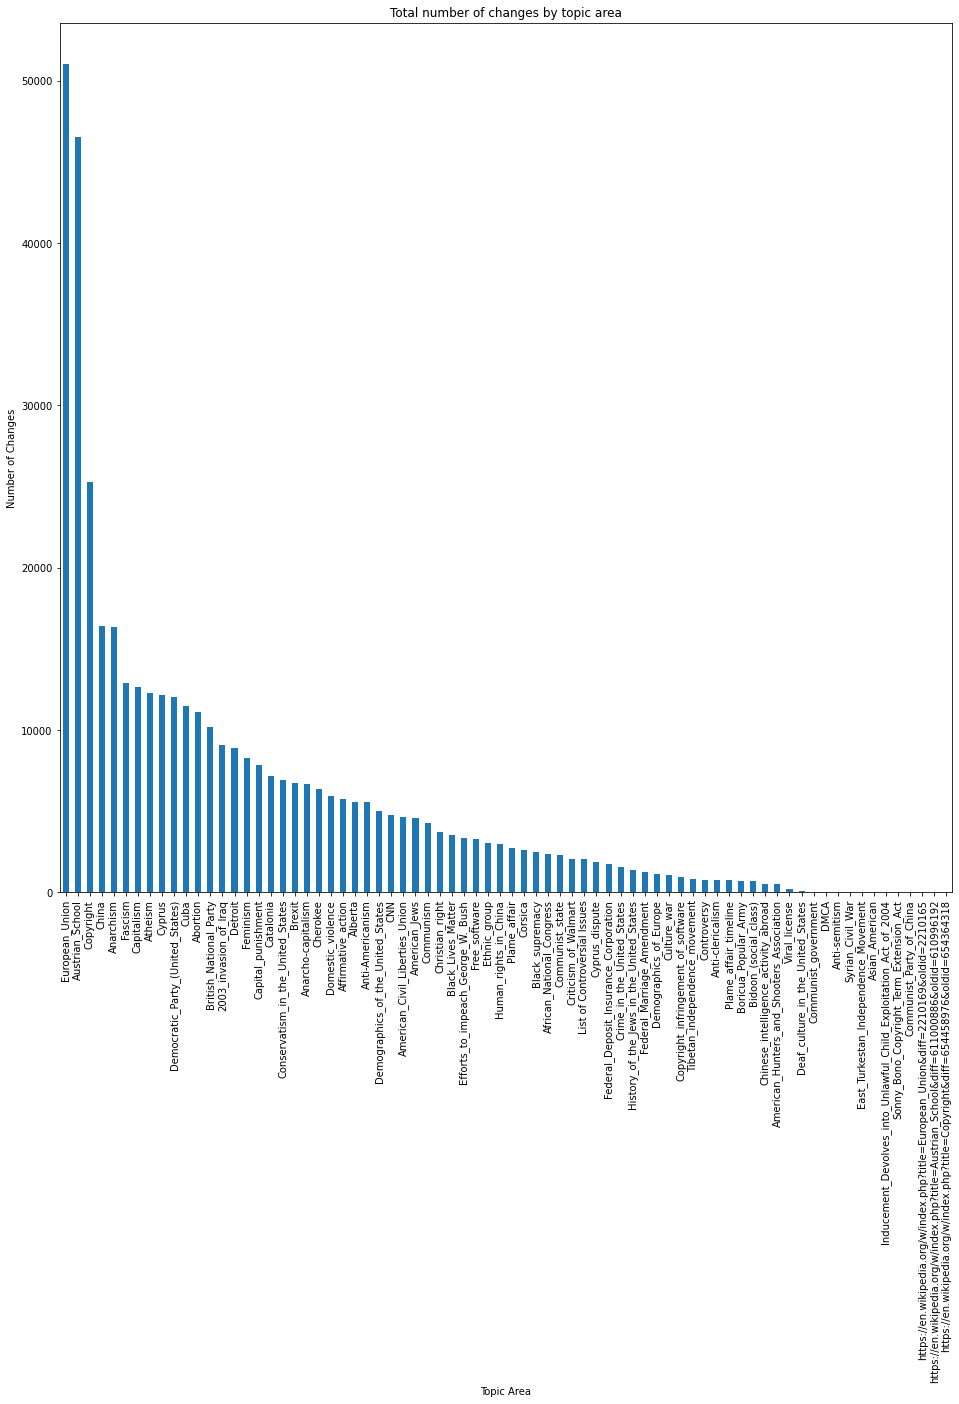

In [8]:
df_all_history['Topic'].value_counts().plot(kind='bar',
                             figsize=(16,16),
                             title='Total number of changes by topic area')
plt.xlabel('Topic Area')
plt.ylabel('Number of Changes');
# There are even controversial topics that don't have very many edits at all
# I need to look more closely at the topics with the most changes
# It's interesting that there are come comments and tags that just talk about undoing things or reverting things.
# Are there characteristics about these reverting information that could suggest that this 
#           revert is a false change? Why do these happen?

In [90]:
df_all_history[df_all_history['has_been_reverted'] == True]
df_all_history.head()

,Unnamed: 0,Page,Topic,Date of Change,User,Bytes,Number of Changes,Comments,Tags,Link To Diff,Diff,has_been_reverted,revert_reason
0,0,https://en.wikipedia.org/w/index.php?title=Wik...,List of Controversial Issues,"05:46, 11 January 2021",2600:1017:b01e:7acc:9867:5ec6:7cdb:da3f,"49,511 bytes",+31,→‎Entertainment,"['Mobile edit', 'Mobile web edit']",https://en.wikipedia.org/w/index.php?title=Wik...,"[[' ', 'Line 636:', ' ', 'Line 636:'], [' ', '...",False,
1,1,https://en.wikipedia.org/w/index.php?title=Wik...,List of Controversial Issues,"02:36, 4 December 2020",2405:7f00:980d:2a00:8996:c69:3a1b:5ae3,"49,480 bytes",+20,No comment,[],https://en.wikipedia.org/w/index.php?title=Wik...,"[[' ', 'Line 172:', ' ', 'Line 172:'], [' ', '...",False,
2,2,https://en.wikipedia.org/w/index.php?title=Wik...,List of Controversial Issues,"17:24, 28 October 2020",Jmg38,"49,460 bytes",−1,→‎People: direct,[],https://en.wikipedia.org/w/index.php?title=Wik...,"[[' ', 'Line 1,029:', ' ', 'Line 1,029:'], [' ...",False,
3,3,https://en.wikipedia.org/w/index.php?title=Wik...,List of Controversial Issues,"18:49, 28 September 2020",Northern Moonlight,"49,461 bytes",−6,"→‎Sex, sexuality, and gender identity",[],https://en.wikipedia.org/w/index.php?title=Wik...,"[[' ', 'Line 566:', ' ', 'Line 566:'], [' ', '...",False,
4,4,https://en.wikipedia.org/w/index.php?title=Wik...,List of Controversial Issues,"03:24, 22 September 2020",Clayoquot,"49,467 bytes",−25,"→‎Environment: Rm * Energy consumption, no id...",[],https://en.wikipedia.org/w/index.php?title=Wik...,"[[' ', 'Line 649:', ' ', 'Line 649:'], [' ', '...",False,


In [ ]:
df_all_history['Date of Change'] = pd.to_datetime(df_all_history['Date of Change'])
df_all_history.head()

In [168]:
just_hitler = df_all_history[df_all_history['Topic'] == 'Adolf_Hitler']

In [169]:
just_hitler.head()

,Page,Topic,Date of Change,User,Bytes,Number of Changes,Comments,Tags
375699,https://en.wikipedia.org/w/index.php?title=:Ad...,Adolf_Hitler,2021-01-12 10:22:00,User:Zeex.rice,"169,363",+22,manual comment: lit template,[Visual edit]
375700,https://en.wikipedia.org/w/index.php?title=:Ad...,Adolf_Hitler,2021-01-11 02:19:00,User:Beyond_My_Ken,"169,341",−12,manual comment: Undid revision 999613552 by <a...,[Undo]
375701,https://en.wikipedia.org/w/index.php?title=:Ad...,Adolf_Hitler,2021-01-11 02:14:00,User:PyroFloe,"169,353",+12,manual comment: Changed image to the coloured ...,[Reverted]
375702,https://en.wikipedia.org/w/index.php?title=:Ad...,Adolf_Hitler,2021-01-10 08:43:00,User:Beyond_My_Ken,"169,341",+6,autocomment:‎top,[]
375703,https://en.wikipedia.org/w/index.php?title=:Ad...,Adolf_Hitler,2021-01-10 08:28:00,User:Maxeto0910,"169,335",0,manual comment: Made more clear that the linke...,"[Mobile edit, Mobile web edit, Visual edit, Ad..."


In [ ]:
just_hitler['Date of Change Reduced'] = pd.to_datetime(just_hitler['Date of Change']).dt.date

In [ ]:
group_by = just_hitler.groupby(['Date of Change Reduced'])['User'].count()
group_by.columns = ['count']

sns.set(rc={'figure.figsize':(16, 16)}) 
ax = sns.lineplot(data = group_by)
ax.set(ylabel='Number of Changes Made', xlabel='Date of Change', title='Number of changes made to the Adolf Hitler page over time')
plt.show()
# Who is making all of those edits to the Adolf Hitler page in 2006? Why are there still peaked days in 2012?
# What kinds of edits are being made? 

In [5]:
web_stats = {'Day': [1, 2, 3, 4, 2, 6],
             'Visitors': [43, 43, 34, 23, 43, 23],
             'Bounce_Rate': [3, 2, 4, 3, 5, 5]}
df_test = pd.DataFrame(web_stats)
#df_test.iloc[0:0]

df_test.head()

,Day,Visitors,Bounce_Rate


In [3]:
df_all_history = pd.read_csv('wikipedia_controversial.csv')
df_all_history.head()

/Library/Python/3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,Page,Topic,Date of Change,User,Bytes,Number of Changes,Comments,Tags,Link To Diff,Diff
0,0,https://en.wikipedia.org/w/index.php?title=Wik...,List of Controversial Issues,"05:46, 11 January 2021",2600:1017:b01e:7acc:9867:5ec6:7cdb:da3f,"49,511 bytes",+31,→‎Entertainment,"['Mobile edit', 'Mobile web edit']",https://en.wikipedia.org/w/index.php?title=Wik...,"[[' ', 'Line 636:', ' ', 'Line 636:'], [' ', '..."
1,1,https://en.wikipedia.org/w/index.php?title=Wik...,List of Controversial Issues,"02:36, 4 December 2020",2405:7f00:980d:2a00:8996:c69:3a1b:5ae3,"49,480 bytes",+20,No comment,[],https://en.wikipedia.org/w/index.php?title=Wik...,"[[' ', 'Line 172:', ' ', 'Line 172:'], [' ', '..."
2,2,https://en.wikipedia.org/w/index.php?title=Wik...,List of Controversial Issues,"17:24, 28 October 2020",Jmg38,"49,460 bytes",−1,→‎People: direct,[],https://en.wikipedia.org/w/index.php?title=Wik...,"[[' ', 'Line 1,029:', ' ', 'Line 1,029:'], [' ..."
3,3,https://en.wikipedia.org/w/index.php?title=Wik...,List of Controversial Issues,"18:49, 28 September 2020",Northern Moonlight,"49,461 bytes",−6,"→‎Sex, sexuality, and gender identity",[],https://en.wikipedia.org/w/index.php?title=Wik...,"[[' ', 'Line 566:', ' ', 'Line 566:'], [' ', '..."
4,4,https://en.wikipedia.org/w/index.php?title=Wik...,List of Controversial Issues,"03:24, 22 September 2020",Clayoquot,"49,467 bytes",−25,"→‎Environment: Rm * Energy consumption, no id...",[],https://en.wikipedia.org/w/index.php?title=Wik...,"[[' ', 'Line 649:', ' ', 'Line 649:'], [' ', '..."


In [4]:
df_all_history = df_all_history[df_all_history['Diff'].notnull()]

In [5]:
for index, row in df_all_history.iterrows():
    for item in ['[', ']', '* ', "' '", 'Line ', ':']:
        try:
            df_all_history.at[index, 'Diff'] = row['Diff'].replace(item, "")
        except:
            print(row['Diff'])

In [6]:
num_changes = pd.DataFrame(columns=['num_changes', 'reasoning', 'comment'])
df_all_history['has_been_reverted'] = False
df_all_history['revert_reason'] = ''
for index, row in df_all_history.iterrows():
    #print(row)
    try:
        if row["Number of Changes"][1:] in num_changes['num_changes'].values.tolist():
            issue = num_changes[num_changes['num_changes'] == row["Number of Changes"][1:]]
            #print(df_all_history.iloc[index])
            df_all_history.at[index, 'has_been_reverted'] = True
            df_all_history.at[index, 'revert_reason'] = issue['reasoning'].values
            num_changes = num_changes[num_changes['num_changes'] != row["Number of Changes"][1:]]  
    except:
        print(row["Number of Changes"][1:])
    for revert_word in [
        'vandalism', 'misinformation', 'nonsense', 'untrue', 
        'nonsensical', 'bad', 'exaggeration', 'un-corroborated', 'No reference', 
        'bot', 'unsourced', 'revert', 'undid', 'rv',
    ]:
        if revert_word.upper() in str(row['Comments']).upper():
            line_for_append = [row["Number of Changes"][1:], revert_word, row["Comments"]]
            num_changes.loc[len(num_changes)] = line_for_append
            #print(num_changes)
            break

In [182]:
a = '-8'
a = int(a)
print(type(a))

<class 'int'>


In [7]:
#df_all_history['Number of Changes'] = pd.to_numeric(df_all_history['Number of Changes'])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

for index, row in df_all_history.iterrows():
    try:
        if row['Number of Changes'][0] == '+':
            df_all_history.at[index, 'Number of Changes'] = int(row['Number of Changes'])
        elif row['Number of Changes'] == '0':
            df_all_history.at[index, 'Number of Changes'] = int(row['Number of Changes'])
        else:
            num = row['Number of Changes'][1:]
            df_all_history.at[index, 'Number of Changes'] = int(num) * -1
    except:
        continue

In [8]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
import spacy
import numpy as np
import dill
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

nlp = spacy.load("en_core_web_sm")

def tokenize_lemma(text):
    return [w.lemma_.lower() for w in nlp(text)]
stop_words_lemma = set(tokenize_lemma(' '.join(STOP_WORDS)))

In [2]:
import sklearn
print(sklearn.__version__)

0.24.2


In [10]:
bigram_est = Pipeline([
    ('stem_vectorizer',
          TfidfVectorizer(min_df = 0.00001,
                  max_df = 0.3,
                  max_features = 10000,
                  #ngram_range=(1,2)
                  stop_words=stop_words_lemma
                  #tokenizer=tokenize_lemma)
    )),
    ('classifier', MultinomialNB(alpha = 3.0))
])
param_grid = {#'stem_vectorizer__max_features': [1000, 3000, 6000, 9000, 11000, 13000], 
              'classifier__alpha': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0],
              'stem_vectorizer__max_df': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
              #'stem_vectorizer__min_df': [0.01, 0.05, 0.1, 0.15, 0.2]
}#'classifier__alpha_1': np.logspace(-3, 3, 20)}#'regressor__max_depth': range(2, 20)} # 10^-3 to 10^3
gs_est = GridSearchCV(bigram_est, param_grid, cv=2, n_jobs=2, verbose=1)
gs_est.fit(df_all_history['Diff'], df_all_history['has_been_reverted'])
gs_est.best_params_
#bigram_est.fit(df_all_history['Diff'], df_all_history['has_been_reverted'])

Fitting 2 folds for each of 48 candidates, totalling 96 fits


{'classifier__alpha': 3.0, 'stem_vectorizer__max_df': 0.3}

In [127]:
estimate = gs_est.predict_proba(['changes_happen'])

In [11]:
with open('tf_text_est.dill', 'wb') as f:
    dill.dump(gs_est, f)

In [80]:
df_for_classification = df_all_history[['Number of Changes', 'has_been_reverted']]
for index, row in df_for_classification.iterrows():
    if isinstance(row['Number of Changes'], int):
        continue
    else:
        df_for_classification.at[index, 'Number of Changes'] = 0
df_for_classification.head()

,Number of Changes,has_been_reverted
0,31,False
1,20,False
2,-1,False
3,-6,False
4,-25,False


In [101]:
with open('tf_num_changes_est.dill', 'wb') as f:
    dill.dump(num_changes_est, f)
#num_changes_est = gs_est

In [90]:
#x = np.array([1,2,3,4,5])
#x.reshape(5, -1)
np.array(df_for_classification['Number of Changes']).reshape(324978, -1)

array([[31],
       [20],
       [-1],
       ...,
       [0],
       [0],
       [0]], dtype=object)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

bigram_est = Pipeline([
    ('classifier', MultinomialNB(alpha = 3.0))
])
param_grid = {#'stem_vectorizer__max_features': [1000, 3000, 6000, 9000, 11000, 13000], 
              'classifier__alpha': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
              #'classifier__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]
            #'stem_vectorizer__max_df': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
              #'stem_vectorizer__min_df': [0.01, 0.05, 0.1, 0.15, 0.2]
}#'classifier__alpha_1': np.logspace(-3, 3, 20)}#'regressor__max_depth': range(2, 20)} # 10^-3 to 10^3
num_changes_est = GridSearchCV(bigram_est, param_grid, cv=3, n_jobs=2, verbose=1)
num_changes_est.fit(np.array(df_for_classification['Number of Changes']).reshape(324978, -1), df_for_classification['has_been_reverted'])
num_changes_est.best_params_

#num_changes_est = Ridge()
#num_changes_est.fit(
#    np.array(df_for_classification['Number of Changes']).reshape(324978, -1), 
#    df_for_classification['has_been_reverted']
#)

In [ ]:
#tried users + changes
bigram_est = Pipeline([
    ('classifier', RandomForestRegressor())
])
param_grid = {#'stem_vectorizer__max_features': [1000, 3000, 6000, 9000, 11000, 13000], 
              #'classifier__alpha': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
              'classifier__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]
              #'stem_vectorizer__max_df': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
              #'stem_vectorizer__min_df': [0.01, 0.05, 0.1, 0.15, 0.2]
}#'classifier__alpha_1': np.logspace(-3, 3, 20)}#'regressor__max_depth': range(2, 20)} # 10^-3 to 10^3
num_changes_est = GridSearchCV(bigram_est, param_grid, cv=3, n_jobs=2, verbose=1)
num_changes_est.fit(df_for_classification, df_for_classification['has_been_reverted'])
num_changes_est.best_params_

In [12]:
new_df = df_all_history[df_all_history['Comments'].notnull()]
#df_all_history['Comments'].fillna(' ')

In [13]:
#'Comments'
bigram_est = Pipeline([
    ('stem_vectorizer',
          CountVectorizer(min_df = 0.00001,
                  max_df = 0.2,
                  max_features = 10000,
                  #ngram_range=(1,2)
                  stop_words=stop_words_lemma
                  #tokenizer=tokenize_lemma)
    )),
    ('classifier', MultinomialNB(alpha = .5))
])
param_grid = {#'stem_vectorizer__max_features': [1000, 3000, 6000, 9000, 11000, 13000], 
              'classifier__alpha': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0],
              'stem_vectorizer__max_df': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
              #'stem_vectorizer__min_df': [0.01, 0.05, 0.1, 0.15, 0.2]
}#'classifier__alpha_1': np.logspace(-3, 3, 20)}#'regressor__max_depth': range(2, 20)} # 10^-3 to 10^3
gs_est = GridSearchCV(bigram_est, param_grid, cv=2, n_jobs=2, verbose=1)
gs_est.fit(new_df['Comments'], new_df['has_been_reverted'])
gs_est.best_params_

Fitting 2 folds for each of 48 candidates, totalling 96 fits


{'classifier__alpha': 0.5, 'stem_vectorizer__max_df': 0.2}

In [14]:
with open('tf_comments_est.dill', 'wb') as f:
    dill.dump(gs_est, f)

In [ ]:
class EstimatorTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, estimator):
        self.est = estimator
        # What needs to be done here?
    
    def fit(self, X, y):
        # Fit the stored estimator.
        # Question: what should be returned?
        self.est.fit(X, y)
        return self
    
    def transform(self, X):
        # Use predict on the stored estimator as a "transformation".
        # Be sure to return a 2-D array.
        array_as_2d = []
        array_as_list = self.est.predict(X)
        for item in array_as_list:
            array_as_2d.append([item])
        return array_as_2d

In [ ]:
from sklearn.pipeline import FeatureUnion

union = FeatureUnion([
    ('city_est', EstimatorTransformer(city_est)),
    ('lon_lat_est', EstimatorTransformer(pipe)),
    ('cat_est', EstimatorTransformer(category_est)),
    ('att_est', EstimatorTransformer(attribute_est))# FeatureUnions use the same syntax as Pipelines
    ])

In [ ]:
union_pipe = Pipeline([
        ('union', union),
        ('estimator', Ridge())
    ])
#print(union_pipe)
union_pipe.fit(data, star_ratings)

In [153]:
df_all_history.head()

,Page,Topic,Date of Change,User,Bytes,Number of Changes,Comments,Tags,Link To Diff


In [42]:
with open('tf_comments_est.dill', 'rb') as f:
    predict_comment = dill.load(f)

predict_comment.classes_

array([False,  True])